#### Stimulus decoding

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import itertools
import os

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from frites.conn.conn_spec import conn_spec
from frites.conn.conn_tf import _tf_decomp
from frites.utils import parallel_func
from scipy.signal import find_peaks
from tqdm import tqdm

from config import sessions
from GDa.session import session, session_info
from GDa.signal.surrogates import trial_swap_surrogates
from GDa.temporal_network import temporal_network
from GDa.util import _extract_roi, average_stages, create_stages_time_grid

In [3]:
tt = br = avg = 1
at = "cue"
_ROOT = os.path.expanduser("~/funcog/gda")

In [4]:
sxx = []
stim = []
i = 0
for s_id in tqdm(["141024"]):
    _FILE_NAME = f"power_tt_{tt}_br_{br}_at_{at}.nc"
    path_pow = os.path.join(_ROOT, f"Results/lucy/{s_id}/session01", _FILE_NAME)
    power = xr.load_dataarray(path_pow)
    # Averages power for each period (baseline, cue, delay, match) if needed
    out = average_stages(power, avg)

    # sxx += [out.sel(roi="V1")]
    # stim += [out.attrs["stim"].astype(int) + 5 * i] * len(out["roi"])
    # i = i + 1

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.12s/it]


In [5]:
attrs = out.attrs
out = out.groupby("roi").mean("roi")
out.attrs = attrs

In [6]:
df = (
    out.assign_coords({"trials": out.stim.astype(int)})
    .to_dataframe(name="power")
    .reset_index()
)

In [7]:
rois = df.roi.unique()

In [8]:
rois_dict = dict(zip(rois, range(len(rois))))

In [9]:
df["roi"] = df["roi"].map(rois_dict)

In [10]:
df.head()

,trials,roi,freqs,times,power
0,5,0,3.0,0,9.196725e-08
1,5,0,3.0,1,4.911998e-08
2,5,0,3.0,2,9.271023e-08
3,5,0,3.0,3,5.901304e-08
4,5,0,3.0,4,3.256154e-08


In [11]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

In [12]:
len(df)

756600

In [13]:
mask = np.zeros(len(df), dtype=bool)
idx = np.random.choice(np.arange(0, len(df)), size=int(len(df) * 0.77), replace=False)
mask[idx] = True

In [14]:
mask.sum() / len(mask)

0.77

In [15]:
x_train, y_train = (
    df.iloc[:, 1:].values[mask, ...],
    df.trials.values[mask],
)

x_test, y_test = (
    df.iloc[:, 1:].values[~mask, ...],
    df.trials.values[~mask],
)

In [16]:
print(x_train.shape)
print(x_test.shape)

(582582, 4)
(174018, 4)


(array([108169., 139120., 120093., 215200.]),
 array([1, 2, 3, 4, 5]),
 <BarContainer object of 4 artists>)

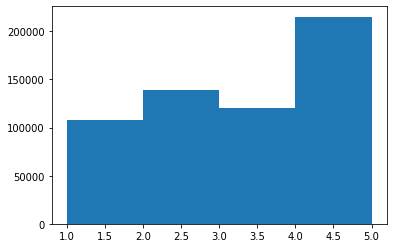

In [17]:
plt.hist(y_train, [1, 2, 3, 4, 5])

(array([32231., 41580., 35907., 64300.]),
 array([1, 2, 3, 4, 5]),
 <BarContainer object of 4 artists>)

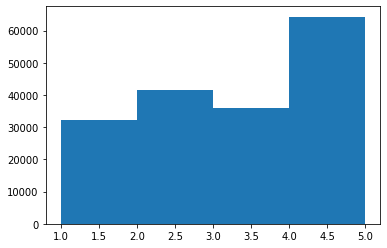

In [18]:
plt.hist(y_test, [1, 2, 3, 4, 5])

In [ ]:
parameters = {
    "n_estimators": np.arange(100, 600, 100, dtype=int),
    "max_depth": np.arange(1, 21, 1),
    "ccp_alpha": np.arange(0.0, 0.4, 0.1),
    "min_samples_split": np.arange(2, 11, 1),
    "min_samples_leaf": np.arange(1, 11, 1),
}

est = RandomForestClassifier(
    n_jobs=20,
    criterion="entropy",
    bootstrap=True,
    verbose=False,
)

clf = GridSearchCV(
    estimator=est,
    param_grid=parameters,
    cv=10,
    scoring="accuracy",
    n_jobs=1,
    return_train_score=True,
    verbose=1,
)

clf.fit(x_train, y_train)

Fitting 10 folds for each of 36000 candidates, totalling 360000 fits


In [ ]:
print(clf.cv_results_["mean_train_score"].argmax())
print(clf.cv_results_["mean_train_score"].max())

In [ ]:
print(clf.cv_results_["mean_test_score"].argmax())
print(clf.cv_results_["mean_test_score"].max())

In [ ]:
best_params = clf.cv_results_["params"][clf.cv_results_["mean_test_score"].argmax()]

In [ ]:
est = RandomForestClassifier(
    n_jobs=20, criterion="entropy", bootstrap=True, verbose=False, **best_params
)

In [ ]:
est.fit(x_train, y_train)

In [ ]:
predictions = est.predict(x_test)

In [ ]:
accuracy_score(predictions, y_test)

In [ ]:
_, c = np.unique(y_test, return_counts=True)

c / len(y_test)

In [ ]:
plt.hist(predictions)